# LWS Visits - Angle Regression
We examine the relationship between targets' rotation angle and the probability that a visits is considered **Lookwing without Seeing** (LWS). We fit a logistic regression model predicting the probability of LWS visits based on the target's rotation angle, with random intercepts for each subject.

In [2]:
import time
from itertools import product

import numpy as np
import bambi as bmb
import arviz as az
import pandas as pd
import polars as pl
from pymer4.models import glmer
import matplotlib.pyplot as plt
from scipy.special import expit
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import config as cnfg
from data_models.LWSEnums import SearchArrayCategoryEnum, ImageCategoryEnum

pio.renderers.default = "notebook"      # or "browser"

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [3]:
VERBOSE = True
EVENT_TYPE, FUNNEL_TYPE = "visit", "lws"
INITIAL_STEP = "instance_on_target"
SEED = 42

if FUNNEL_TYPE == "lws":
    STEPS = cnfg.LWS_FUNNEL_STEPS
elif FUNNEL_TYPE == "target_return":
    STEPS = cnfg.TARGET_RETURN_FUNNEL_STEPS
else:
    raise NotImplementedError(f"Unknown FUNNEL_TYPE: {FUNNEL_TYPE}")

## Prepare Data

In [4]:
from funnel.prepare import prepare_funnel

DATA = prepare_funnel(
    data_dir=cnfg.OUTPUT_PATH,
    funnel_type=FUNNEL_TYPE,
    event_type=EVENT_TYPE,
    verbose=VERBOSE,
)
DATA = DATA.assign(abs_angle=lambda df: df["target_angle"].abs())
SUBSET = DATA[DATA[INITIAL_STEP]]   # Only consider events that passed the initial step

print(f"Empirical probability that a {EVENT_TYPE} is LWS given it passed the initial step `{INITIAL_STEP}`:\t{100 * DATA['final'].sum() / DATA[INITIAL_STEP].sum() :.2f}%")

Calculating Funnel Steps: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\prepare.py:222: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Applying Funnel: 100%|██████████| 1396/1396 [00:06<00:00, 199.92it/s]


Empirical probability that a visit is LWS given it passed the initial step `instance_on_target`:	26.17%


## Simple Hierarchical Model
We fit a hierarchical logistic regression model predicting the probability of an event passing the `final` funnel step given it passed the `INITIAL_STEP`.<br>
In the **simple model** we only include the (absolute) target rotation-angle as a predictor, with random intercepts for each subject:
$$logit(final) \sim 1 + abs(target\_angle) + (1 | subject) $$

In [5]:
FORMULA_1 = "final ~ 1 + abs_angle + (1 | subject)"

### (1) Frequentist Model

In [6]:
freq_model1 = glmer(formula=FORMULA_1, data=pl.from_pandas(SUBSET), family="binomial",)
freq_model1.set_factors({
    "subject": SUBSET["subject"].unique().sort_values().map(str, na_action="").tolist(),
})
results = freq_model1.fit(summary=True, exponentiate=False)
results

GT(_tbl_data=shape: (5, 10)
┌────────────────┬─────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param       ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str         ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪═════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ subject-sd     ┆ (Intercept) ┆ 0.307904  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null        ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null        ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept) ┆ -1.039879 ┆ -1.296012 ┆ … ┆ -7.957307 ┆ inf  ┆ <.001   ┆ ***   │
│ null           ┆ abs_angle   ┆ -0.001497 ┆ -0.017314 ┆ … ┆ -0.185479 ┆ inf  ┆ 0.8529  ┆       │
└────────────────┴─────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x00000172D8CB94C0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000172D8CB9EE0>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(final~1+abs_angle+(1|subject))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *2308*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-1314*  \n            AIC: *2635* | BIC: *2652*  \n            Residual error: *1.0*  \n        '), preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x00000172D8CBA150>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x00000172D8CB97C0>, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None, mask=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weigh

In [12]:
freq_model1.emmeans("abs_angle")

abs_angle_trend,SE,df,asymp_LCL,asymp_UCL
f64,f64,f64,f64,f64
-0.001497,0.00807,inf,-0.017314,0.01432


### (2) Bayesian Model

In [13]:
start = time.time()

bayes_model1 = bmb.Model(FORMULA_1, SUBSET, family="bernoulli")
bayes_idata1 = bayes_model1.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)

elapsed = time.time() - start
print(f"Model fitting completed in {int(elapsed // 3600)}:{int((elapsed % 3600) // 60)}:{elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, abs_angle, 1|subject_sigma, 1|subject_offset]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.


Model fitting completed in 0:1:7.86 (hh:mm:ss)


In [16]:
az.summary(bayes_idata1, var_names=["Intercept", "abs_angle"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.0358,0.1460,-1.3162,-0.7681,0.0027,0.0019,2869.8172,3614.0424,1.0005
abs_angle,-0.0015,0.0082,-0.0171,0.0138,0.0001,0.0001,8613.0711,5608.3924,0.9999


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'abs_angle'}>,
        <Axes: title={'center': 'abs_angle'}>]], dtype=object)

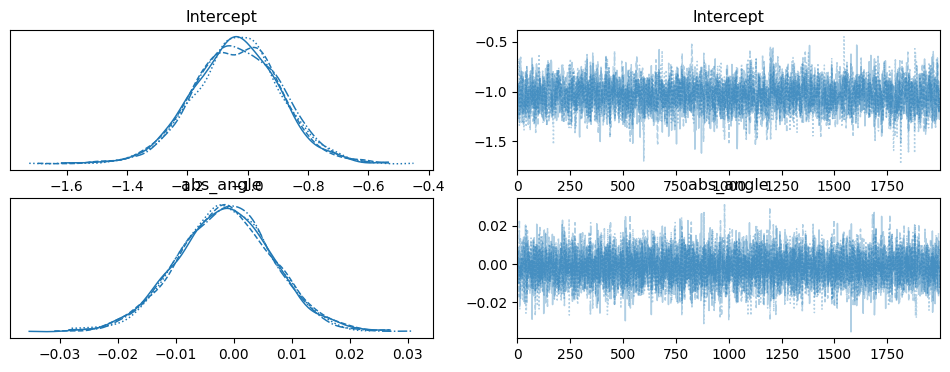

In [19]:
az.plot_trace(bayes_idata1, var_names=["Intercept", "abs_angle"])

## Hierarchical Multi-Regression - Trial Category
We extend the original model by including the trial category as an additional predictor, as well as the interaction between trial category and target rotation angle. Like before, we include random intercepts for each subject:
$$logit(final) \sim 1 + abs(target\_angle) * C(trial\_category) + (1 | subject) $$

In [20]:
FORMULA_2 = "final ~ 1 + abs_angle * trial_category + (1 | subject)"

### (1) Frequentist Model

In [25]:
freq_model2 = glmer(formula=FORMULA_2, data=pl.from_pandas(SUBSET), family="binomial",)
freq_model2.set_factors({
    "subject": SUBSET["subject"].unique().sort_values().map(str, na_action="").tolist(),
    "trial_category": SUBSET["trial_category"].unique().sort_values().tolist(),
})
results = freq_model2.fit(summary=True, exponentiate=False)
results

GT(_tbl_data=shape: (9, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ subject-sd     ┆ (Intercept)    ┆ 0.297159  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -1.256916 ┆ -1.622674 ┆ … ┆ -6.735364 ┆ inf  ┆ <.001   ┆ ***   │
│ null           ┆ abs_angle      ┆ 0.006664  ┆ -0.021503 ┆ … ┆ 0.463682  ┆ inf  ┆ 0.6429  ┆       │
│ null           ┆ trial_category ┆ 0.525861  ┆ 0.050869  ┆ … ┆ 2.169863  ┆ inf  ┆ 0.03002 ┆ *     │
│                ┆ BW             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ trial_category ┆ 0.238167  ┆ -0.211539 ┆ … ┆ 1.038008  ┆ inf  ┆ 0.2993  ┆       │
│                ┆ NOISE          ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:tria ┆ -0.01504  ┆ -0.054162 ┆ … ┆ -0.753502 ┆ inf  ┆ 0.4511  ┆       │
│                ┆ l_categoryBW   ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:tria ┆ -0.018652 ┆ -0.058152 ┆ … ┆ -0.925528 ┆ inf  ┆ 0.3547  ┆       │
│                ┆ l_categoryNOIS ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ E              ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x00000172D610BF80>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000172D60ED3D0>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(final~1+abs_angle*trial_category+(1|subject))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *2308*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-1308*  \n            AIC: *2630* | BIC: *2671*  \n            Residual error: *1.0*  \n        '), preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x00000172D610AA20>, _summary_rows_grand=<great_tables._gt_data.SummaryRo

In [28]:
freq_model2.emmeans("abs_angle")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



abs_angle_trend,SE,df,asymp_LCL,asymp_UCL
f64,f64,f64,f64,f64
-0.004567,0.008146,inf,-0.020533,0.011399


### (2) Bayesian Model

In [31]:
start = time.time()

bayes_model2 = bmb.Model(FORMULA_2, SUBSET, family="bernoulli")
bayes_idata2 = bayes_model2.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)

elapsed = time.time() - start
print(f"Model fitting completed in {int(elapsed // 3600)}:{int((elapsed % 3600) // 60)}:{elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, abs_angle, trial_category, abs_angle:trial_category, 1|subject_sigma, 1|subject_offset]
Sampling 4 chains for 1_000 tune and 2_000 draw ite

Model fitting completed in 0:1:28.68 (hh:mm:ss)


In [32]:
az.summary(bayes_idata2, var_names=["Intercept", "abs_angle", "trial_category", "abs_angle:trial_category"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.2317,0.1982,-1.6213,-0.8855,0.0039,0.0027,2580.3143,3747.7186,1.0008
abs_angle,0.0045,0.0141,-0.0225,0.0303,0.0002,0.0002,3622.7983,4793.9576,1.0004
trial_category[BW],0.4797,0.2366,0.0384,0.9235,0.0039,0.0025,3619.3568,4545.3632,1.0005
trial_category[NOISE],0.2109,0.2222,-0.1946,0.6449,0.0036,0.0023,3872.2282,5258.5533,1.0006
abs_angle:trial_category[BW],-0.0114,0.0196,-0.0481,0.0250,0.0003,0.0002,3411.6195,4359.9178,1.0007
abs_angle:trial_category[NOISE],-0.0163,0.0196,-0.0546,0.0181,0.0003,0.0002,3542.2807,5134.1398,1.0004


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'abs_angle'}>,
        <Axes: title={'center': 'abs_angle'}>],
       [<Axes: title={'center': 'trial_category'}>,
        <Axes: title={'center': 'trial_category'}>]], dtype=object)

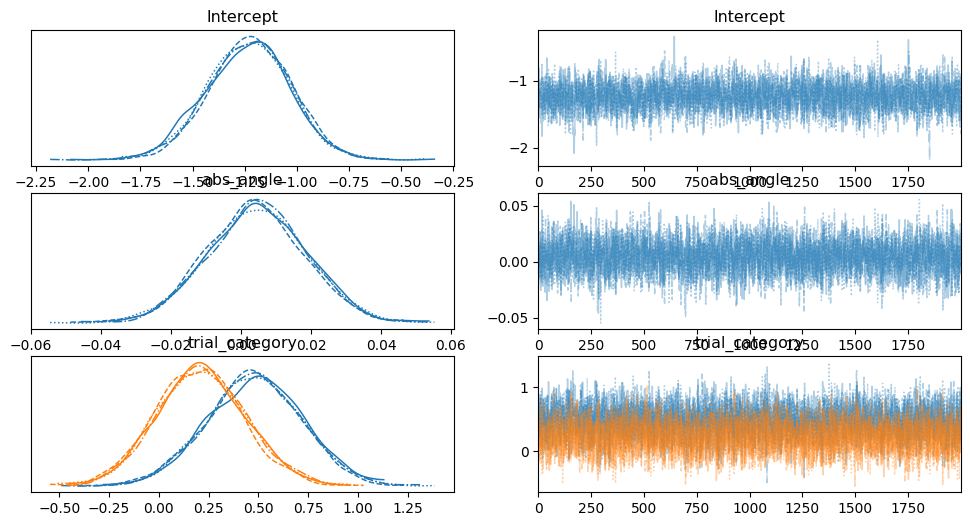

In [33]:
az.plot_trace(bayes_idata2, var_names=["Intercept", "abs_angle", "trial_category"])

## Hierarchical Multi-Regression - Target Category
We extend the original model by including the target category as an additional predictor, as well as the interaction between target category and target rotation angle. Like before, we include random intercepts for each subject:
$$logit(final) \sim 1 + abs(target\_angle) * C(target\_category) + (1 | subject) $$

In [35]:
FORMULA_3 = "final ~ 1 + abs_angle * target_category + (1 | subject)"

### (1) Frequentist Model

In [36]:
freq_model3 = glmer(formula=FORMULA_3, data=pl.from_pandas(SUBSET), family="binomial",)
freq_model3.set_factors({
    "subject": SUBSET["subject"].unique().sort_values().map(str, na_action="").tolist(),
    "target_category": SUBSET["target_category"].unique().sort_values().tolist()
})
results = freq_model3.fit(summary=True, exponentiate=False)
results

GT(_tbl_data=shape: (15, 10)
┌────────────┬───────────────────┬───────────┬───────────┬───┬───────────┬──────┬──────────┬───────┐
│ rfx        ┆ param             ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value  ┆ stars │
│ ---        ┆ ---               ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---   │
│ str        ┆ str               ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str      ┆ str   │
╞════════════╪═══════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪══════════╪═══════╡
│ subject-sd ┆ (Intercept)       ┆ 0.300958  ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ null       ┆ null              ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ Fixed      ┆ null              ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ Effects:   ┆                   ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ (Intercept)       ┆ -0.703264 ┆ -1.192925 ┆ … ┆ -2.814958 ┆ inf  ┆ 0.004878 ┆ **    │
│ null       ┆ abs_angle         ┆ -0.006056 ┆ -0.044254 ┆ … ┆ -0.310737 ┆ inf  ┆ 0.756    ┆       │
│ …          ┆ …                 ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …        ┆ …     │
│ null       ┆ abs_angle:target_ ┆ -0.00084  ┆ -0.050701 ┆ … ┆ -0.033012 ┆ inf  ┆ 0.9737   ┆       │
│            ┆ categoryHUMAN…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ abs_angle:target_ ┆ 0.00531   ┆ -0.048766 ┆ … ┆ 0.192452  ┆ inf  ┆ 0.8474   ┆       │
│            ┆ categoryANIMA…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ abs_angle:target_ ┆ -0.006727 ┆ -0.06013  ┆ … ┆ -0.246913 ┆ inf  ┆ 0.805    ┆       │
│            ┆ categoryHUMAN…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ abs_angle:target_ ┆ 0.005502  ┆ -0.056219 ┆ … ┆ 0.174704  ┆ inf  ┆ 0.8613   ┆       │
│            ┆ categoryOBJEC…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ abs_angle:target_ ┆ 0.020947  ┆ -0.038907 ┆ … ┆ 0.685924  ┆ inf  ┆ 0.4928   ┆       │
│            ┆ categoryOBJEC…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
└────────────┴───────────────────┴───────────┴───────────┴───┴───────────┴──────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x00000172D9EAA6C0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000172D9EA9190>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(final~1+abs_angle*target_category+(1|subject))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *2308*  \n            Confidence intervals: *parametric*  \n            --------------

In [37]:
freq_model3.emmeans("abs_angle")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



abs_angle_trend,SE,df,asymp_LCL,asymp_UCL
f64,f64,f64,f64,f64
-0.002024,0.008419,inf,-0.018525,0.014476


### (2) Bayesian Model

In [39]:
start = time.time()

bayes_model3 = bmb.Model(FORMULA_3, SUBSET, family="bernoulli")
bayes_idata3 = bayes_model3.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)

elapsed = time.time() - start
print(f"Model fitting completed in {int(elapsed // 3600)}:{int((elapsed % 3600) // 60)}:{elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, abs_angle, target_category, abs_angle:target_category, 1|subject_sigma, 1|subject_offset]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 100 seconds.


Model fitting completed in 0:1:47.27 (hh:mm:ss)


In [40]:
az.summary(
    bayes_idata3,
    var_names=["Intercept", "abs_angle", "target_category", "abs_angle:target_category"],
    round_to=4
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.7793,0.2352,-1.2415,-0.3574,0.0041,0.0027,3251.3821,4545.6244,1.0005
abs_angle,-0.0004,0.0178,-0.0339,0.0334,0.0003,0.0002,2959.7810,4306.8415,1.0001
target_category[HUMAN_OTHER],0.0612,0.2811,-0.4571,0.5937,0.0045,0.0029,3948.5894,4977.6311,1.0001
target_category[ANIMAL_FACE],0.1293,0.2986,-0.4176,0.6975,0.0046,0.0033,4159.5138,5329.8194,1.0001
target_category[HUMAN_FACE],-0.2560,0.2979,-0.8078,0.2992,0.0048,0.0030,3879.5166,4983.9614,1.0009
target_category[OBJECT_HANDMADE],-0.6949,0.3275,-1.3090,-0.0784,0.0049,0.0033,4495.1746,5587.0729,1.0007
target_category[OBJECT_NATURAL],-0.8091,0.3189,-1.4094,-0.2106,0.0048,0.0033,4438.3654,5439.6630,1.0000
abs_angle:target_category[HUMAN_OTHER],-0.0061,0.0238,-0.0520,0.0375,0.0004,0.0003,3599.8663,4537.3090,1.0003
abs_angle:target_category[ANIMAL_FACE],0.0003,0.0255,-0.0470,0.0493,0.0004,0.0003,4047.6260,5499.5064,1.0006
abs_angle:target_category[HUMAN_FACE],-0.0133,0.0254,-0.0592,0.0356,0.0004,0.0003,3846.0254,5000.3957,1.0004


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'abs_angle'}>,
        <Axes: title={'center': 'abs_angle'}>],
       [<Axes: title={'center': 'target_category'}>,
        <Axes: title={'center': 'target_category'}>]], dtype=object)

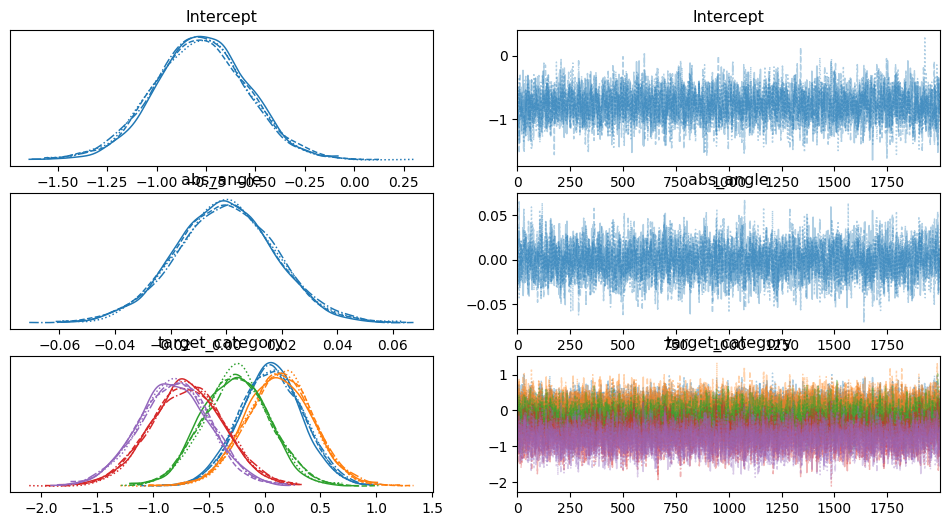

In [42]:
az.plot_trace(bayes_idata3, var_names=["Intercept", "abs_angle", "target_category"])

## Complete Hierarchical Regression
We apply the complete model, examining the effects of `target_angle`, `target_category`, `trial_category` and their interactions on the probability of LWS. Like before, we include random intercepts for each subject:
$$logit(final) \sim 1 + abs(target\_angle) * C(target\_category) * C(trial\_category) + (1 | subject) $$

In [43]:
FORMULA_4 = "final ~ 1 + abs_angle * target_category * trial_category + (1 | subject)"

### (1) Frequentist Model

In [44]:
freq_model4 = glmer(formula=FORMULA_4, data=pl.from_pandas(SUBSET), family="binomial",)
freq_model4.set_factors({
    "subject": SUBSET["subject"].unique().sort_values().map(str, na_action="").tolist(),
    "target_category": SUBSET["target_category"].unique().sort_values().tolist(),
    "trial_category": SUBSET["trial_category"].unique().sort_values().tolist(),
})
results = freq_model4.fit(summary=True, exponentiate=False)
results

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.004407925

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.004407925



GT(_tbl_data=shape: (39, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ subject-sd     ┆ (Intercept)    ┆ 0.299482  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -0.284954 ┆ -1.305593 ┆ … ┆ -0.547206 ┆ inf  ┆ 0.5842  ┆       │
│ null           ┆ abs_angle      ┆ -0.042675 ┆ -0.123503 ┆ … ┆ -1.034808 ┆ inf  ┆ 0.3008  ┆       │
│ …              ┆ …              ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …       ┆ …     │
│ null           ┆ abs_angle:targ ┆ -0.130621 ┆ -0.260086 ┆ … ┆ -1.977478 ┆ inf  ┆ 0.04799 ┆ *     │
│                ┆ et_categoryHUM ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ AN…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:targ ┆ -0.033089 ┆ -0.170547 ┆ … ┆ -0.471801 ┆ inf  ┆ 0.6371  ┆       │
│                ┆ et_categoryANI ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ MA…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:targ ┆ 0.011927  ┆ -0.121649 ┆ … ┆ 0.175001  ┆ inf  ┆ 0.8611  ┆       │
│                ┆ et_categoryHUM ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ AN…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:targ ┆ -0.056811 ┆ -0.243881 ┆ … ┆ -0.595216 ┆ inf  ┆ 0.5517  ┆       │
│                ┆ et_categoryOBJ ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ EC…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ abs_angle:targ ┆ 0.031656  ┆ -0.12437  ┆ … ┆ 0.397659  ┆ inf  ┆ 0.6909  ┆       │
│                ┆ et_categoryOBJ ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ EC…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x000001731E31D550>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label=

In [45]:
freq_model4.emmeans("abs_angle")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



abs_angle_trend,SE,df,asymp_LCL,asymp_UCL
f64,f64,f64,f64,f64
-0.000376,0.009034,inf,-0.018082,0.01733


In [46]:
freq_model4.emmeans("trial_category", contrasts="pairwise", p_adjust="tukey")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,odds_ratio,SE,df,asymp_LCL,asymp_UCL,null,z_ratio,p_value
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""COLOR / BW""",0.64782,0.084524,inf,0.477144,0.879546,1.0,-3.327414,0.002524
"""COLOR / NOISE""",0.949936,0.123725,inf,0.70004,1.289039,1.0,-0.394334,0.917867
"""BW / NOISE""",1.466359,0.182041,inf,1.096172,1.96156,1.0,3.083355,0.005804


In [47]:
freq_model4.emmeans(
    "target_category",
    contrasts={
        "HUMAN_minus_ANIMAL": [-0.5, 0.5, -0.5, 0.5, 0, 0],
        "FACE_minus_OTHER": [-0.5, -0.5, 0.5, 0.5, 0, 0],
        "ANIMATE_minus_INANIMATE": [0.25, 0.25, 0.25, 0.25, -0.5, -0.5]
    },
    p_adjust="sidak",
    type="response",
)

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,odds_ratio,SE,df,asymp_LCL,asymp_UCL,null,z_ratio,p_value
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""HUMAN_minus_ANIMAL""",0.722299,0.084372,inf,0.546496,0.954656,1.0,-2.784998,0.015973
"""FACE_minus_OTHER""",0.861633,0.100569,inf,0.652058,1.138566,1.0,-1.275929,0.491793
"""ANIMATE_minus_INANIMATE""",2.047038,0.24535,inf,1.53758,2.7253,1.0,5.977131,6.8131e-9


### (2) Bayesian Model

In [48]:
start = time.time()

bayes_model4 = bmb.Model(FORMULA_4, SUBSET, family="bernoulli")
bayes_idata4 = bayes_model4.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)

elapsed = time.time() - start
print(f"Model fitting completed in {int(elapsed // 3600)}:{int((elapsed % 3600) // 60)}:{elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, abs_angle, target_category, abs_angle:target_category, trial_category, abs_angle:trial_category, target_category:trial_category, abs_angle:target_category:trial_category, 1|subject_sigma, 1|subject_offset]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 226 seconds.


Model fitting completed in 0:3:58.44 (hh:mm:ss)


In [51]:
az.summary(
    bayes_idata4,
    var_names=["Intercept", "abs_angle", "target_category", "trial_category"],
    round_to=4
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.8670,0.3049,-1.4492,-0.3056,0.0048,0.0033,4007.6283,5137.4506,1.0005
abs_angle,-0.0015,0.0244,-0.0478,0.0436,0.0004,0.0002,3543.7845,5046.5037,1.0011
target_category[HUMAN_OTHER],-0.1430,0.3640,-0.8149,0.5409,0.0054,0.0037,4628.4129,5355.5414,1.0001
target_category[ANIMAL_FACE],0.0863,0.3909,-0.6264,0.8497,0.0057,0.0039,4734.9438,5679.9161,1.0003
target_category[HUMAN_FACE],-0.1421,0.3694,-0.8467,0.5457,0.0053,0.0037,4883.6494,5853.3669,1.0007
target_category[OBJECT_HANDMADE],-1.1404,0.4571,-1.9779,-0.2769,0.0065,0.0047,4974.2709,5846.7289,1.0013
target_category[OBJECT_NATURAL],-0.6693,0.3955,-1.3828,0.0942,0.0055,0.0040,5108.6842,5454.8143,1.0006
trial_category[BW],0.3923,0.3513,-0.2839,1.0548,0.0050,0.0035,4872.8891,5666.7046,1.0000
trial_category[NOISE],-0.0126,0.3229,-0.6242,0.5869,0.0047,0.0033,4675.6917,5627.1746,1.0004


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'abs_angle'}>,
        <Axes: title={'center': 'abs_angle'}>],
       [<Axes: title={'center': 'target_category'}>,
        <Axes: title={'center': 'target_category'}>],
       [<Axes: title={'center': 'trial_category'}>,
        <Axes: title={'center': 'trial_category'}>]], dtype=object)

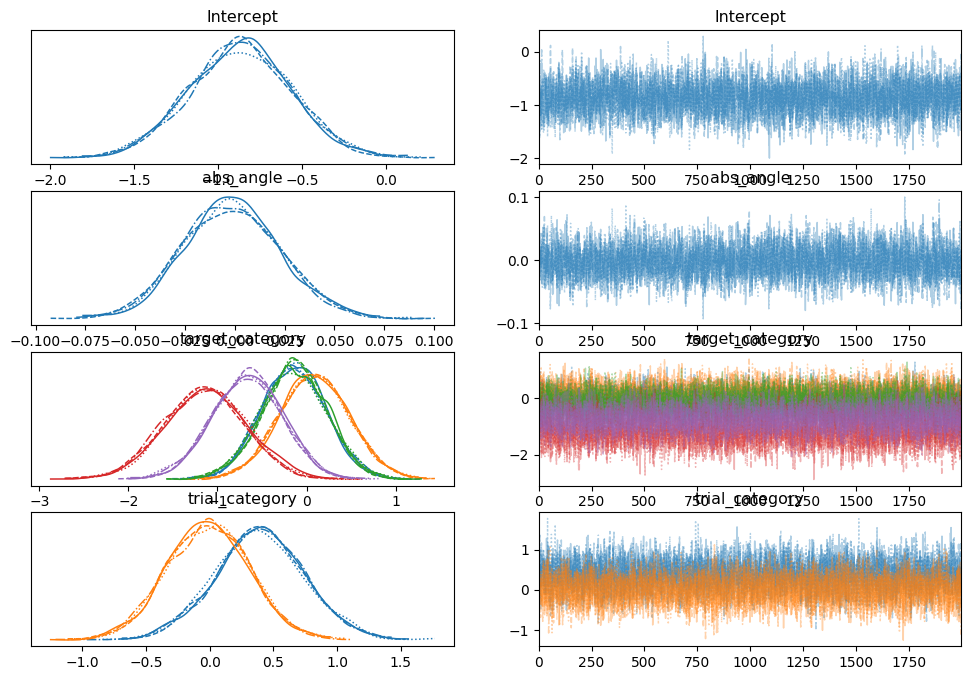

In [50]:
az.plot_trace(bayes_idata4, var_names=["Intercept", "abs_angle", "target_category", "trial_category"])